In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import matplotlib.pyplot as plt
import h5py
import numpy as np
import get_xyz
import constants
from pathlib import Path
import hdf5plugin
import streak_finder as sf
import add_geometry_streaks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


streak lengths: [ 9.37612367  8.12188585  7.70649488  8.35818627 10.02086202 11.80327681
  8.78329342  8.86356506 10.46618288  8.85082265  9.92730022  8.13496376
  9.05743614  7.93657532  9.5216034   9.80272949 12.06366882 13.17010353
 12.76699872 11.41000058 14.71214474 12.65155195 10.94359248 14.22130368
 10.20198455 10.45698051 15.39340203 11.39470219 12.55899    12.50989071
 12.1167424  11.68286511 15.11467198 15.65601562 13.46897746  7.68088531
 13.38929266 15.46735872 17.44920377 13.03151048 16.97352564 16.27832939
 12.76864431 16.17243136 16.10325109 15.22819878 17.57822773 14.26705378
 15.12864736 14.56372618 16.10808563 13.36242202 17.26644031 14.22034732
 16.80250512 16.46027199 18.42718888 17.05652502 18.05148438 20.76213191
 22.45107204 23.10833905 17.71712186 15.71526359 23.80627249 20.02597822
 22.01357091 34.79712513]
number of streaks: 68


100%|██████████| 68/68 [00:00<00:00, 64762.19it/s]
/tmp/ipykernel_1712113/3142305385.py:70: RuntimeWarning: invalid value encountered in power
  im = frame_im[::-1, ::-1]**0.1


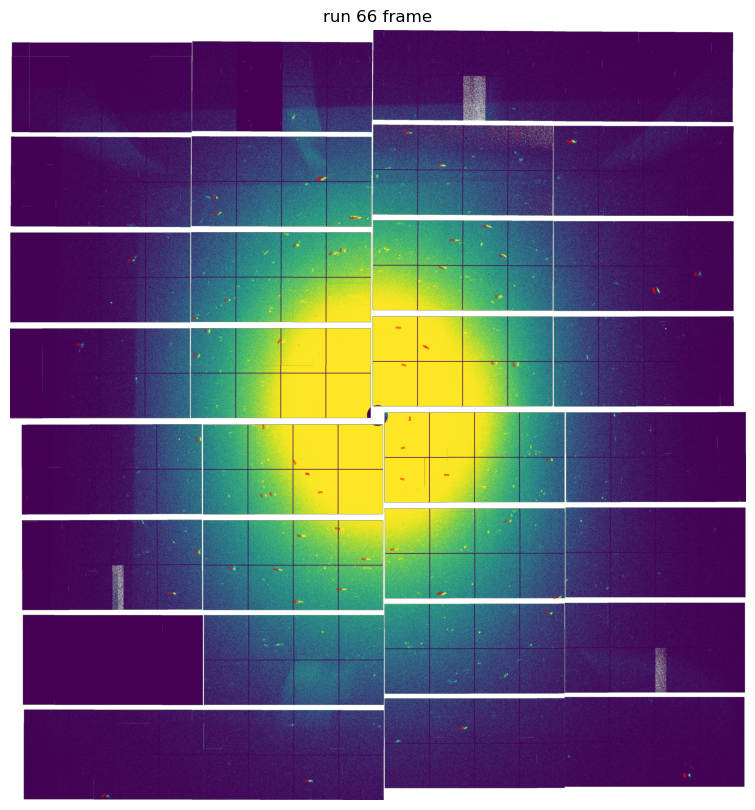

In [18]:
run = 66

# find pattern with a lot of streaks
fnam = Path(constants.beamtime_dir) / f'work/streaks/streaks_run{run:>04}.h5'
if fnam.is_file() and False:
    with h5py.File(fnam) as f:
        streaks = f['fs0_ss0_fs1_ss1_slab'][()]
        pid = np.squeeze(f['pulse_id'][()])
        print(pid.dtype)
        fnams = f['file_name'][()]
        file_index = f['file_index'][()]

    i = np.where(pid == 24771632355)[0][0]
    # streaks_pid = np.bincount(pid-pid.min())
    #j = np.argsort(streaks_pid)[-1]
    #pid_max = int(j + pid.min())
    # i = np.where(pid_max==pid)[0][0]
    print(i)
    fnam = fnams[i]
    index = file_index[i]
    print(f'max number of streaks for frame in file {streaks_pid[j]}')
else:
    index = 105
    fnam = Path(constants.beamtime_dir) / f'raw/run{run:>04}/data/acq0005.JF07T32V02.h5'

with h5py.File(fnam) as f:
    mask = f['/data/JF07T32V02/meta/pixel_mask'][()]
    frame = f['/data/JF07T32V02/data'][index]
    
frame0 = frame.copy().astype(float)

whitefield_fnam = Path(f'{constants.work}/whitefield/whitefield_run{run:>04}.h5')
assert(whitefield_fnam.is_file())

with h5py.File(whitefield_fnam) as f:
    whitefield = f['whitefield'][()]

whitefield[whitefield == 0] = 1

# scale whitefield
c = np.sum(mask * whitefield * frame) / np.sum(mask * whitefield**2)
frame = np.clip((frame - c * whitefield) / (c * whitefield)**0.5, 0, None)

params = sf.scripts.StreakFinderParameters.read('streak_finder_params.json', 'json')

det_obj = sf.streak_finder.PatternStreakFinder(data=frame, mask=mask, structure=params.streaks.structure.to_structure('2d'),
                                               min_size=params.streaks.min_size, nfa=params.streaks.nfa)

peaks = det_obj.detect_peaks(vmin=params.peaks.vmin, npts=params.peaks.npts, connectivity=params.peaks.structure.to_structure('2d'),
                             num_threads=1)

streaks = det_obj.detect_streaks(peaks, xtol=params.streaks.xtol, vmin=params.streaks.vmin, num_threads=1)

t = streaks[0].to_lines() # (num_streaks, 4) numpy array

x0, y0, x1, y1 = t.T
length = ((x1-x0)**2 + (y1-y0)**2)**0.5
print(f'streak lengths: {length}')
print(f'number of streaks: {t.shape[0]}')

# t = np.array([t[np.argmax(length)]])

if t.shape[0] > 0:
    # apply geometry to frame and peaks
    frame_im, centre = get_xyz.geom_cor(frame0)
    t = add_geometry_streaks.apply_geom_streaks(t)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    im = frame_im[::-1, ::-1]**0.1
    ax.imshow(im, aspect='equal', origin='upper', vmin=np.percentile(im[im>0], 1), vmax=np.percentile(im[im>0], 90))
    
    # plot 1000 streaks
    for s in t:
        ax.plot(-s[1::2]-centre[1], -s[0::2]-centre[0], c='red', alpha=0.5)

    # ax.set_xlim([1000, 2000])
    # ax.set_ylim([3000, 4000])
    ax.set_axis_off()
    ax.set_title(f'run {run} frame')
    plt.show()


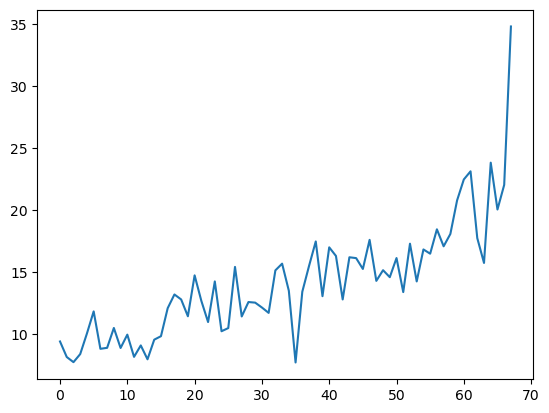

In [17]:
plt.plot(length)